In [2]:
import pandas as pd
import seaborn as sns 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import sys
sys.path.append('../../code')
import leakage


In [3]:
data_folder = Path('../../data')
figure_folder = Path('../../Figures/')
div_folder = Path('../../../data/this_project/5_div/')


## Get extracellular data

In [4]:
sintef_fn = data_folder / 'this_project/1_e_coli_batch_cultures/1ABE_merged_metabolomics_data.csv'
sintef_od_fn = data_folder / 'this_project/1_e_coli_batch_cultures/1H_OD_and_gDW.csv'

paczia_fn = data_folder / 'paczia_2012' / 'e_coli'/'e_coli_exometabolites.csv'
paczia_od_fn = data_folder / 'paczia_2012' / 'e_coli'/'e_coli_OD.csv'

vila_fn = data_folder / 'vila_2023' / 'Targeted_LCMS_WithOD.csv'


## Sintef

In [5]:
sintef_df = pd.read_csv(sintef_fn, index_col=0)
# Only intrerested in the absolute quantification
sintef_df = sintef_df.loc[sintef_df['Concentration [uM]'].notna()]

In [6]:
sintef_od = pd.read_csv(sintef_od_fn, index_col = 0)

In [7]:
sintef_od_dict = sintef_od.set_index(['Hours', 'Bioreactor'])['OD'].to_dict()

In [8]:
sintef_od_dict[0, np.nan] = np.nan

In [9]:
sintef_df['OD'] = sintef_df.apply(lambda x: sintef_od_dict[x['Hours'], x['Bioreactor']], axis=1)

#### Delta concentration

In [10]:
sintef_t0 = sintef_df.loc[sintef_df.Hours ==0]
sintef_conc0_dict = sintef_t0.groupby(['Carbon source', 'Metabolite']).mean('Concentration [uM]')['Concentration [uM]'].to_dict()

In [11]:
def get_delta_concentration(x):
    c = x['Concentration [uM]']
    try:
        c0 = sintef_conc0_dict[x['Carbon source'], x['Metabolite']]
    except KeyError:
        return c
    else:
        return c-c0

In [12]:
sintef_df['Delta concentration [uM]'] = sintef_df.apply(lambda x:get_delta_concentration(x), axis = 1)


In [13]:
sintef_df.loc[sintef_df['Delta concentration [uM]']< 0, 'Delta concentration [uM]'] = np.nan

In [14]:
sintef_df.loc[sintef_df.Timepoint==4, 'Phase'] = 'Stationary'
sintef_df.loc[sintef_df.Timepoint.isin([1,2,3]), 'Phase'] = 'Exponential'

## Paczia

In [15]:
paczia_df, paczia_df_std = leakage.get_concentrations(paczia_fn.parent, 'e_coli')

In [16]:
paczia_df = paczia_df.loc[2:] - paczia_df.loc[1]

In [17]:
paczia_od = pd.read_csv(paczia_od_fn)

In [18]:
paczia_time_to_od = paczia_od.set_index('Time')['OD mean'].to_dict()

In [19]:
paczia_df['2PG'] =  paczia_df['3PG'] = paczia_df['23PG']/2
paczia_df['RU5P'] = paczia_df['X5P'] = paczia_df['RU5P+X5P']/2

In [20]:
paczia_df.drop(columns=['23PG', 'RU5P+X5P'], inplace=True)

In [21]:
paczia_dfL = paczia_df.reset_index().melt(id_vars='Time', var_name='Abbreviation', value_name='Delta concentration [uM]')
paczia_dfL['OD'] = paczia_dfL.Time.map(paczia_time_to_od)

In [22]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv_paczia = {value:key for key, value in met_abrv_to_name.items()}
met_abrv_to_name['SER'] = 'Serine'
met_abrv_to_name['DHAP'] = 'Dihydroxyacetone phosphate'
met_abrv_to_name['2PG'] = '2-phosphoglycerate'
met_abrv_to_name['3PG'] = '3-phosphoglycerate'
met_abrv_to_name['X5P'] = 'Xylulose-5-phosphate'
met_abrv_to_name['RU5P'] = 'Ribulose-5-phosphate'

In [23]:
paczia_dfL['Metabolite'] = paczia_dfL.Abbreviation.map(met_abrv_to_name)

In [24]:
paczia_dfL.loc[paczia_dfL.Time <= 10, 'Phase'] = 'Exponential'
paczia_dfL.loc[paczia_dfL.Time > 10, 'Phase'] = 'Stationary'

In [25]:
paczia_dfL.loc[paczia_dfL['Delta concentration [uM]'] < 0, 'Delta concentration [uM]'] = np.nan

## Vila


In [26]:
vila_df = pd.read_csv(vila_fn)
vila_df = vila_df.loc[vila_df.Strain == 'Ecoli']
metname_translate_dict = {'Acetic acid': 'Acetate',
'Acetyl-ornithine': 'Acetyl-ornithine',
'Alanine': 'Alanine',
'Asparagine': 'Asparagine',
'Butyric acid': 'Butyrate',
'Citric acid': 'Citrate',
'Fumaric acid': 'Fumarate',
'Glycine': 'Glycine',
'Lactic acid': 'Lactate',
'Methionine': 'Methionine',
'Propionic acid': 'Propionate',
'Putrescine': 'Putrescine',
'Pyruvic acid': 'Pyruvate',
'Serine': 'Serine',
'Succinic acid': 'Succinate',
'Valeric acid':'Valerate',
'Valine': 'Valine',
'alpha-Ketoglutaric acid': 'Alpha-ketoglutarate',
'beta-Hydroxybutyric acid': 'Beta-hydroxybutyrate'}
vila_df['Metabolite'] = vila_df.Metabolite.map(metname_translate_dict)

In [27]:
vila_df['Delta concentration [uM]'] = vila_df.Metabolite_Conc
vila_df.loc[vila_df.Metabolite_Conc==0, 'Delta concentration [uM]'] = np.nan

In [28]:
vila_peak_df = pd.read_csv(data_folder / 'vila_2023' / 'growth_curves_peaktimes.csv', index_col=0)
strain_cs_to_PT = vila_peak_df.groupby(['Strain', 'Carbon source']).agg({'Peak time':'max'}).to_dict()['Peak time']


In [29]:
time_buffer = 2
for i, row in vila_df.iterrows():
    peak_time = strain_cs_to_PT[row['Strain'], row['Carbon_Source']]
    if row['Timepoint'] < peak_time+2:
        vila_df.at[i, 'Phase'] = 'Exponential'
    else:
        vila_df.at[i, 'Phase'] = 'Stationary'

In [30]:
vila_df['Hours'] = vila_df['Timepoint']
vila_df.rename(columns={'Carbon_Source':'Carbon source'}, inplace=True)

## Join dataframes

In [31]:
vila_mets = set(vila_df.Metabolite.unique())
paczia_mets = set(paczia_dfL.Metabolite.unique())
sintef_mets = set(sintef_df.Metabolite.unique())
# ps_mets = vila_mets & sintef_mets
vila_only = vila_mets - paczia_mets - sintef_mets

In [32]:
paczia_dfL['Hours'] = paczia_dfL['Time']
paczia_dfL['Carbon source'] = 'Glucose'

In [33]:
df_ex = pd.concat([sintef_df, paczia_dfL, vila_df])[['Hours', 'Delta concentration [uM]', 'OD', 'Phase', 'Metabolite', 'Carbon source']]

In [34]:
df_ex = df_ex.loc[~df_ex.isna().any(axis=1)]

In [35]:
df_ex

,Hours,Delta concentration [uM],OD,Phase,Metabolite,Carbon source
810,10.0,0.017935,2.1900,Exponential,Alpha-aminoadipate,L-malate
811,16.0,0.104060,0.8900,Exponential,Alpha-aminoadipate,L-alanine
812,12.0,0.035617,2.5700,Stationary,Alpha-aminoadipate,L-malate
817,14.0,0.076829,2.8900,Exponential,Alpha-aminoadipate,Galactose
820,12.0,0.014934,1.6300,Exponential,Alpha-aminoadipate,Galactose
...,...,...,...,...,...,...
2515,48.0,0.609000,0.1141,Exponential,Butyrate,Pyruvate
2516,48.0,0.271000,0.1141,Exponential,Methionine,Pyruvate
2517,48.0,2740.000000,0.1141,Exponential,Acetate,Pyruvate
2518,48.0,1.880000,0.1141,Exponential,Citrate,Pyruvate


## Get intracellular literature data

In [36]:
conditions_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4F_mapped_intracellular_conc.csv'
conditions_df = pd.read_csv(conditions_fn, index_col=0)

In [37]:
list(conditions_df.Metabolite.unique())

['Alanine',
 'Alpha-aminoadipate',
 'Asparagine',
 'Aspartate',
 'Beta-alanine',
 'Cis-aconitate',
 'Creatine',
 'Deoxycarnitine (deoxy-c0)',
 'Gamma-aminobutyrate',
 'Glutamate',
 'Glutamine',
 'Glutarate',
 'Glutarylcarnitine (c5-dc)',
 'Isocitrate',
 'Isoleucine',
 'Lactate',
 'Leucine',
 'Lysine',
 'Malate',
 'Methionine',
 'NAD',
 'Phenylalanine',
 'Pipecolic acid',
 'Proline',
 'Sebacoyl-l-carnitine (c10-dc)',
 'Serine',
 'Succinate',
 'Trans-aconitate',
 'Tyrosine',
 'Valine',
 'Citrate',
 'Acetate',
 'Formate',
 'Propanoate',
 'Pyruvate',
 'Alpha-aminobutyrate',
 'Glycine',
 'Hexoses',
 'Glucose-6-phosphate',
 'Fructose-6-phosphate',
 'Fructose-1,6-bisphosphate',
 'Dihydroxyacetone phosphate',
 'Glyceraldehyde-3-phosphate',
 '2-phosphoglycerate',
 '3-phosphoglycerate',
 'Phosphoenolpyruvate',
 'Ribose-5-phosphate',
 'Ribulose-5-phosphate',
 'Xylulose-5-phosphate',
 'Erythrose-4-phosphate',
 'Oxaloacetate',
 'Threonine',
 'Homoserine',
 'Tryptophan',
 'Histidine',
 'Arginine',
 

# Merge intracellular and extracellular

In [38]:
df_ex['Carbon source'] = df_ex['Carbon source'].str.capitalize()
df_ex['Carbon source'] = df_ex['Carbon source'].replace({'D-glucose': 'Glucose'})

In [39]:
df = pd.merge(left = df_ex, right = conditions_df, left_on=['Metabolite', 'Carbon source', 'Phase'], 
              right_on=['Metabolite', 'Carbon source', 'Phase'], how = 'left')


In [40]:
# df.to_csv(figure_folder / '5B_exometabolites.csv', index=False)

In [41]:
df = df.loc[df['Intracellular concentration [uM]'].notna()].copy()

In [42]:
total_cell_volume_per_od = 3.6 # uL per OD per mL Total cell volume conversion, see Volkmer and Heinemann 2011, https://pmc.ncbi.nlm.nih.gov/articles/PMC3146540/


In [43]:
# 1e-6 to convert from uL to L and 1e3 to convert from ml to L (so net 1e-3)
df['Corresponding Ex. concentration [uM]']= total_cell_volume_per_od*df['OD']*1e-3*df['Intracellular concentration [uM]']


In [44]:
df['Fraction of cells needed'] = df['Delta concentration [uM]']/df['Corresponding Ex. concentration [uM]']

In [45]:
df = df.loc[df['Delta concentration [uM]']>0]

In [46]:
df.sort_values(by = 'Metabolite', inplace=True)

In [47]:
df['Fraction of cells needed'].sort_values()

264         0.000368
586         0.000765
934         0.000883
465         0.001499
600         0.001527
            ...     
1494    16246.558800
1583    16640.855982
1598    17387.702447
1833    17530.469304
1728    23188.778058
Name: Fraction of cells needed, Length: 1514, dtype: float64

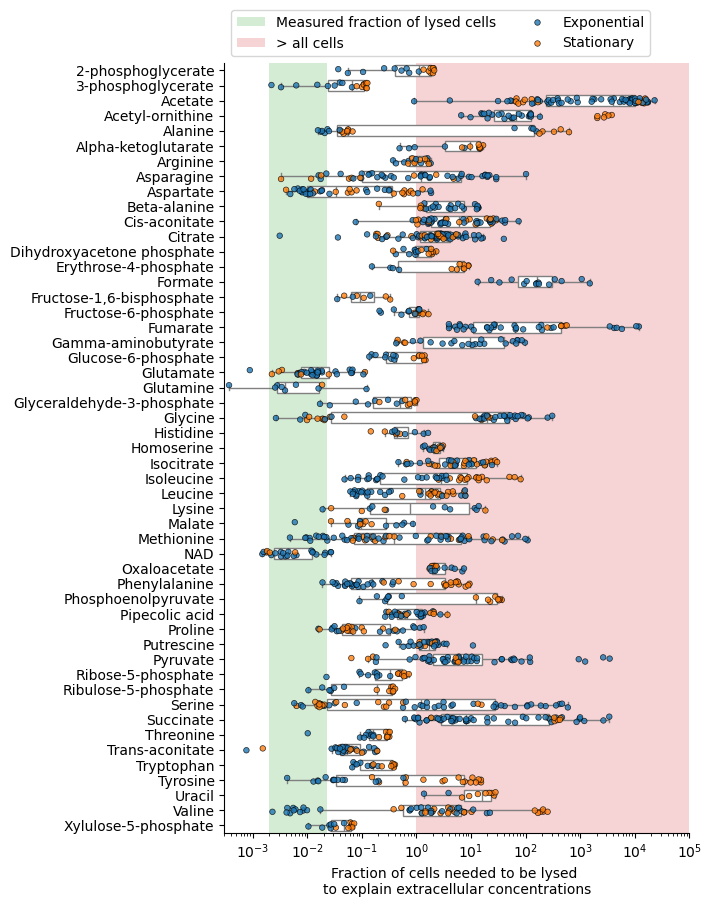

In [48]:
fig, ax = plt.subplots(1, figsize = (6, 10))
ax.set_xscale('log')

ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axvspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, x = 'Fraction of cells needed', y = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey')
sns.stripplot(data = df, x = 'Fraction of cells needed', y = 'Metabolite', ax = ax, edgecolor = 'k', 
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Phase', alpha = 0.8)#, color = 'C0')
ax.set_xlim(3e-4, 1e5)
ax.set_ylabel('')
ax.set_xlabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed.pdf', bbox_inches='tight')

3.7e-04, 2.3e+04


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_50497/3812360702.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


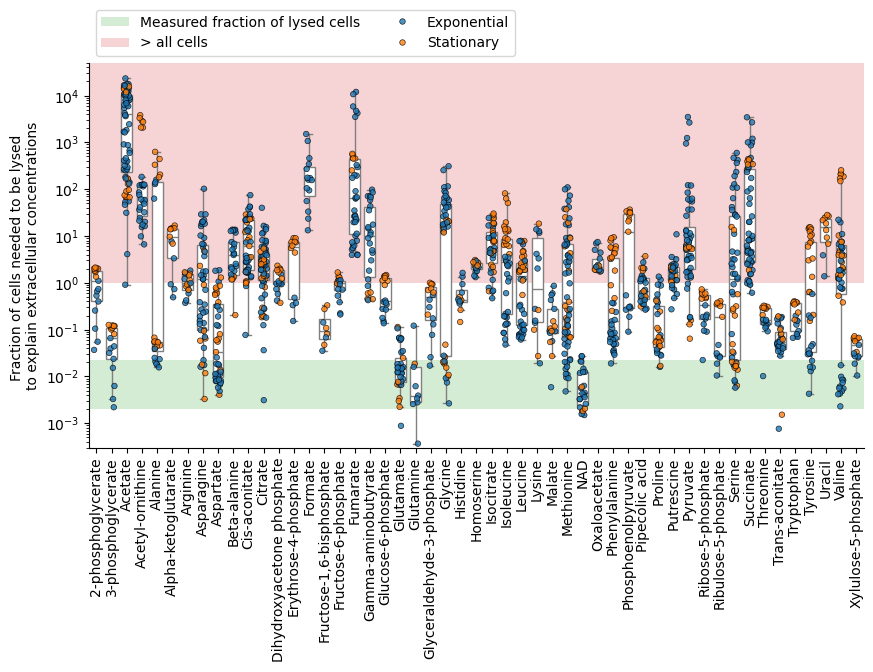

In [91]:
fig, ax = plt.subplots(1, figsize = (10, 5))
# ax.set_yscale('log')

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, y = 'Fraction of cells needed', x = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey', log_scale=True)
sns.stripplot(data = df,y = 'Fraction of cells needed', x = 'Metabolite', ax = ax, edgecolor = 'k', 
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Phase', alpha = 0.8, log_scale=True)#, color = 'C0')
ax.set_ylim(3e-4, 5e4)
print(f'{df['Fraction of cells needed'].min():.1e}, {df['Fraction of cells needed'].max():.1e}')
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_horizontal.pdf', bbox_inches='tight')

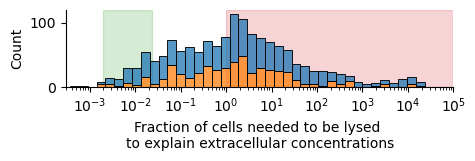

In [49]:
fig, ax = plt.subplots(1, figsize = (5, 1))
sns.histplot(data = df, x = 'Fraction of cells needed', log_scale=True, bins = 40, ax = ax, hue = 'Phase', multiple='stack',
             legend=False
             )

ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axvspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
# sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
ax.set_xlim(3e-4, 1e5)
ax.set_xlabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')

sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_hist.pdf', bbox_inches='tight')


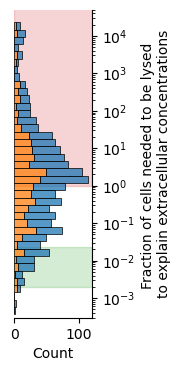

In [92]:
fig, ax = plt.subplots(1, figsize = (1, 4))
sns.histplot(data = df, y = 'Fraction of cells needed', log_scale=True, bins = 40, ax = ax, hue = 'Phase', multiple='stack',
             legend=False
             )

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
# sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
ax.set_ylim(3e-4, 5e4)
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.despine(left = True, right = False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


plt.savefig(figure_folder / '5F_fraction_of_cells_needed_hist_vertical.pdf', bbox_inches='tight')


(0.0003, 100000.0)

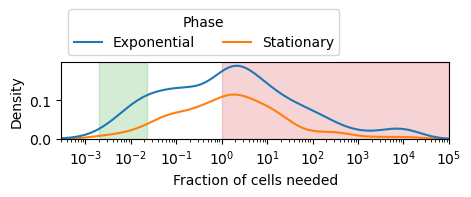

In [51]:
fig, ax = plt.subplots(1, figsize = (5, 1))
sns.kdeplot(data = df, x = 'Fraction of cells needed', log_scale=True, ax = ax, hue = 'Phase')
ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axvspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2)
ax.set_xlim(3e-4, 1e5)


In [93]:
(df['Fraction of cells needed']<0.023).sum()

np.int64(157)

In [94]:
(df['Fraction of cells needed']<0.023).sum()/len(df['Fraction of cells needed'])

np.float64(0.1036988110964333)

In [95]:
(df['Fraction of cells needed']>1).sum(), (df['Fraction of cells needed']>1).sum()/len(df['Fraction of cells needed'])

(np.int64(855), np.float64(0.5647291941875826))

In [96]:
len(df['Fraction of cells needed']>1)

1514

# Include protein depolymerization

In [56]:
aa_mass_fractions = {
    'ala__L': 0.046,
    'arg__L': 0.052,
    'asp__L': 0.026,# Halv of the joint asp/asn value
    'asn__L': 0.026,# Halv of the joint asp/asn value
    'cys__L': 0.01,
    'glu__L': 0.0245, # Halv of the joint glu/gln value
    'gln__L': 0.0245, # Halv of the joint glu/gln value
    'gly': 0.025,
    'his__L': 0.012,
    'ile__L': 0.026,
    'leu__L': 0.05,
    'lys__L': 0.036,
    'met__L': 0.018,
    'phe__L': 0.028,
    'pro__L': 0.022,
    'ser__L': 0.021,
    'thr__L': 0.028,
    'trp__L': 0.012,
    'tyr__L': 0.016,
    'val__L': 0.033
}


OD_to_gDW = 0.346 # gDW/L/OD


metabolite_to_bigg_aa = {
    'Leucine': 'leu__L',
    'Glutamate': 'glu__L',
    'Aspartate': 'asp__L',
    'Asparagine': 'asn__L',
    'Glutamine': 'gln__L',
    'Alanine': 'ala__L',
    'Glycine': 'gly',
    'Serine': 'ser__L', 
    'Threonine': 'thr__L',
    'Valine': 'val__L',
    'Isoleucine': 'ile__L',
    'Phenylalanine': 'phe__L',
    'Tyrosine': 'tyr__L',
    'Tryptophan': 'trp__L',
    'Cysteine': 'cys__L',
    'Histidine': 'his__L',
    'Methionine': 'met__L',
    'Proline': 'pro__L',
    'Arginine': 'arg__L',
    'Lysine': 'lys__L'
    }

aa_mol_weight_dict = {
    'ala__L': 89.1,
    'arg__L': 174.2,
    'asp__L': 133.1,
    'asn__L': 132.1,
    'cys__L': 121.2,
    'glu__L': 147.1,
    'gln__L': 146.2,
    'gly': 75.1,
    'his__L': 155.2,
    'ile__L': 131.2,
    'leu__L': 131.2,
    'lys__L': 146.2,
    'met__L': 149.2,
    'phe__L': 165.2,
    'pro__L': 115.1,
    'ser__L': 105.1,
    'thr__L': 119.1,
    'trp__L': 204.2,
    'tyr__L': 181.2,
    'val__L': 117.1
}

OD_to_gDW = defaultdict(lambda: 0.36)

OD_to_gDW.update({
    'Glucose': 0.346,
    'Galactose': 0.346,
    'L-malate': 0.279,
    'L-alanine': 0.296,
})

In [57]:
df['gDW/L'] = df['OD'] * df['Carbon source'].map(OD_to_gDW)

In [58]:
df_AA = df.loc[df['Metabolite'].isin(metabolite_to_bigg_aa.keys())].copy()

In [59]:
for i, row in df_AA.iterrows():
    aa = metabolite_to_bigg_aa[row['Metabolite']]
    df_AA.at[i, 'gAA/L'] = row['gDW/L'] * aa_mass_fractions[aa]
    # Substract water weight (18.02 g/mol) because one water molecule is lost during protein synthesis
    df_AA.at[i, 'AA uM'] = df_AA.at[i, 'AA uM'] = df_AA.at[i, 'gAA/L'] / (aa_mol_weight_dict[aa]-18.02) *1e6

In [60]:
df_AA[r'Fraction of cells needed (100% depolymerization)'] = df['Delta concentration [uM]']/(df_AA['AA uM']+df_AA['Corresponding Ex. concentration [uM]'])
df_AA[r'Fraction of cells needed (10% depolymerization)'] = df['Delta concentration [uM]']/((0.1*df_AA['AA uM'])+df_AA['Corresponding Ex. concentration [uM]'])

In [61]:
df_death_aaL = df_AA.melt(id_vars=['Metabolite', 'Phase'],
                                value_vars=['Fraction of cells needed (100% depolymerization)',
                                            'Fraction of cells needed (10% depolymerization)',
                                            'Fraction of cells needed'
                                ],
                                var_name='Protein depolymerization', value_name='Fraction needed')

df_death_aaL.replace({'Protein depolymerization':
                      {'Fraction of cells needed': '0%',
                        'Fraction of cells needed (10% depolymerization)': '10%',
                        'Fraction of cells needed (100% depolymerization)': '100%',}}, inplace=True)


In [62]:
df_death_aaL

,Metabolite,Phase,Protein depolymerization,Fraction needed
0,Alanine,Stationary,100%,0.000310
1,Alanine,Stationary,100%,0.000319
2,Alanine,Stationary,100%,0.000264
3,Alanine,Stationary,100%,0.000386
4,Alanine,Exponential,100%,2.888366
...,...,...,...,...
1942,Valine,Exponential,0%,10.983251
1943,Valine,Exponential,0%,1.844914
1944,Valine,Stationary,0%,147.870015
1945,Valine,Stationary,0%,3.912986


In [63]:
df_death_aaL.columns

Index(['Metabolite', 'Phase', 'Protein depolymerization', 'Fraction needed'], dtype='object')

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_50497/2305368278.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', size = 12)


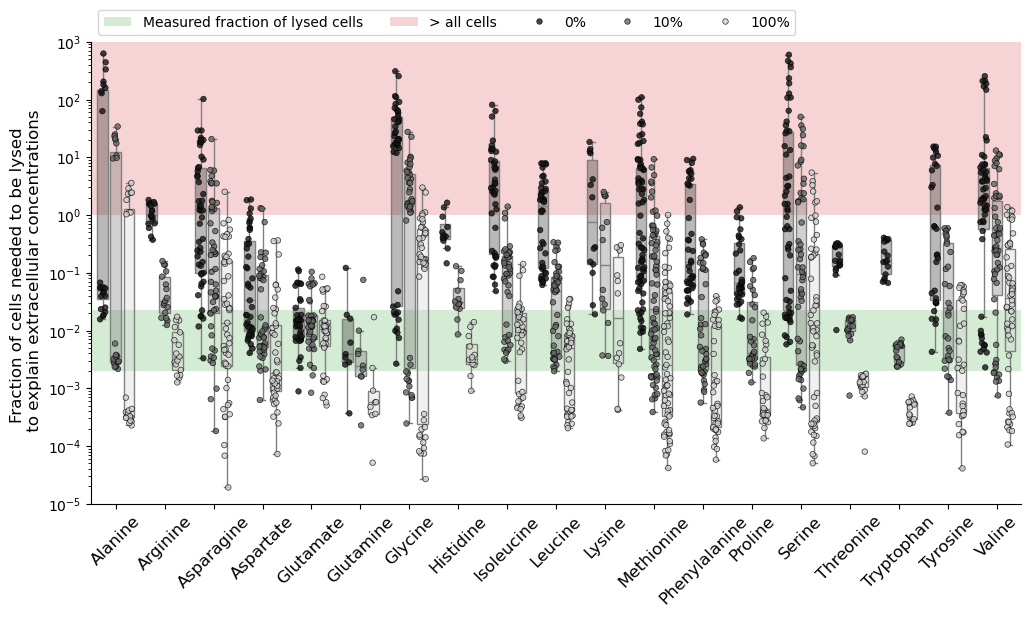

In [64]:
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.set_yscale('log')
gray_colors = [ "#171717", "#666666", "#cfcfcf"]
hue_order = ['0%', '10%', '100%']
ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
sns.boxplot(df_death_aaL, y = 'Fraction needed', x = 'Metabolite', fill=True,gap=.2,
                ax = ax, hue = 'Protein depolymerization', legend = None,fliersize = 0,
                 linecolor = 'grey', palette=gray_colors, hue_order=hue_order)#, boxprops=dict(alpha=.3))
sns.stripplot(data = df_death_aaL, y = 'Fraction needed', x = 'Metabolite', ax = ax, edgecolor = 'k',
              dodge=True, 
              hue_order=hue_order,
              palette=gray_colors,
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Protein depolymerization', alpha = 0.8)#, color = 'C0')

for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor((*fc[:3], 0.3))  # Set alpha to 0.3
# for patch in ax.artists:
#     print(patch)
#     fc = patch.get_facecolor()
#     patch.set_facecolor(plt.colors.to_rgba(fc, 0.3))
# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', size = 12)
# print(df_death_aaL['Fraction needed'].min(), df_death_aaL['Fraction needed'].max())
ax.set_ylim(1e-5, 1e3)
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \n to explain extracellular concentrations', fontsize=12)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 5, title = '')
sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_AA.pdf', bbox_inches='tight')

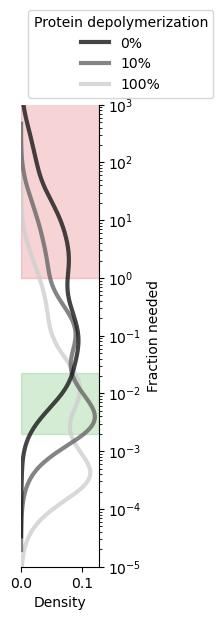

In [76]:
fig, ax = plt.subplots(1, figsize = (1, 6))
sns.kdeplot(data = df_death_aaL, y = 'Fraction needed', log_scale=True, ax = ax, 
            hue = 'Protein depolymerization', palette=gray_colors, lw = 3, 
            hue_order=hue_order,
            alpha = 0.8)
ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 1)
ax.set_ylim(1e-5, 1e3)
sns.despine(left = True, right = False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_AA_kde.pdf', bbox_inches='tight')


In [66]:
ax.artists

<Axes.ArtistList of 0 artists>

In [67]:
for patch in ax.artists:
    print(patch)
    fc = patch.get_facecolor()
    patch.set_facecolor(plt.colors.to_rgba(fc, 0.3))

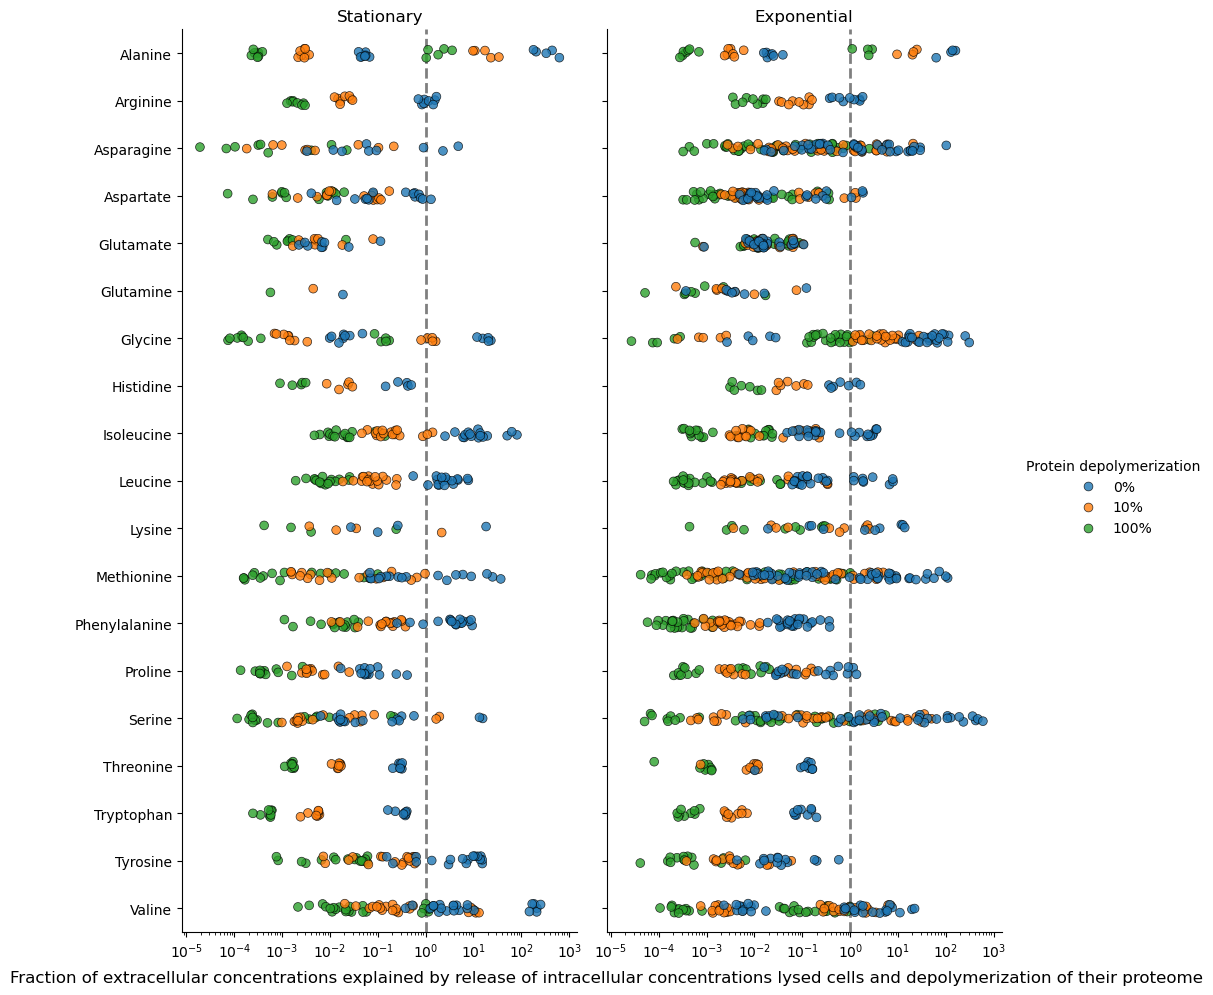

In [68]:

strip = sns.catplot(df_death_aaL, x = 'Fraction needed', #hue = 'Protein depolymerization',
                        y = 'Metabolite',col = 'Phase',
                        hue= 'Protein depolymerization',
                        log_scale=True,
                        edgecolor = 'k', linewidth = 0.5, alpha = 0.8,\
                        s = 40,
                        kind = 'strip',
                        hue_order=['0%', '10%', '100%'],
                        height=10, aspect=0.5,
                    #    figsize=(6, 3), 
                    #    order=aa_metabolite_order
                       )
strip.set_titles(col_template="{col_name}", row_template="{row_name}", size = 12)
strip.set_axis_labels("","")
strip.figure.supxlabel("Fraction of extracellular concentrations explained by release of " \
"intracellular concentrations lysed cells and depolymerization of their proteome", size = 12)

sns.despine()

for ax in strip.axes.flat:
    ax.axvline(x=1, color='k', ls='--', lw=2, alpha=0.5, zorder = 0)
# yticks = np.arange(len(metabolite_order))
# for i, y in enumerate(yticks):
#     color = "#ffffff" if i % 2 == 0 else "#eeeded"
#     strip.axes[0,0].axhspan(y - 0.5, y + 0.5, color=color, zorder=0)


# fig_fn = figure_folder / '2_paired_death_1_with_aa.pdf'
# plt.savefig(fig_fn, bbox_inches='tight')